In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from __future__ import print_function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import shutil

In [ ]:
# %ls

In [ ]:
# %cd ..
# %cd ..
# shutil.rmtree('EVA8')

In [2]:
!git clone https://github.com/shreyash-99/EVA8.git
%cd EVA8/EVA8-all_models-new
from utils import *
from main import *

Cloning into 'EVA8'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 762 (delta 79), reused 106 (delta 40), pack-reused 613
Receiving objects: 100% (762/762), 9.52 MiB | 28.02 MiB/s, done.
Resolving deltas: 100% (443/443), done.
/content/EVA8/EVA8-all_models-new


In [ ]:
%cd ..
%cd Session_9_Assignment
from model9 import *
%cd ..

/content/EVA8
/content/EVA8/Session_9_Assignment
/content/EVA8


In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
BATCH_SIZE = 512
train_data_lrfinder = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=128,
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(Albumentation_cifar_Dataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

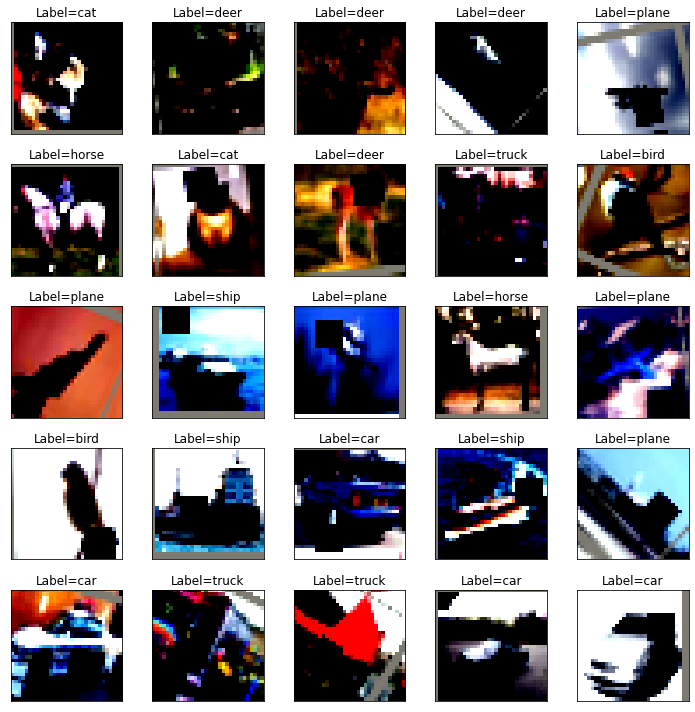

In [5]:
visualize_augmented_images(train_loader, classes, 5,5)

In [42]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model()
model = model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]          13,872
       BatchNorm2d-8           [-1, 48, 32, 32]              96
              ReLU-9           [-1, 48, 32, 32]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             384
           Linear-12                    [-1, 8]             384
           Linear-13                    [-1, 8]             384
           Linear-14              

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.50E-01


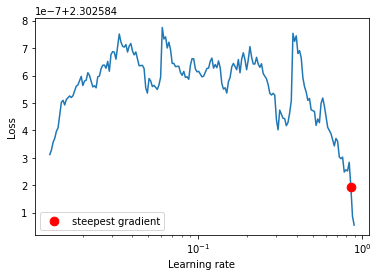

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.8504489341802678)

In [44]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder
import copy

# model = custom_ResNet().to(device)
model_exp = copy.deepcopy(model)

optimizer = torch.optim.SGD(model_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_data_lrfinder, end_lr=1,  num_iter=200)
print(lr_finder)
lr_finder.plot()

In [47]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.9329304026284686


In [48]:
# model_new = custom_ResNet().to(device)
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr= 0.005,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

In [49]:

net, history = fit_model(
    net=model, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0005)


Batch_id=97 Loss=2.11505 Accuracy=17.09%: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 1.9508, Accuracy: 1844/10000 (18.44%)

EPOCH: 2 (LR: 0.0014394972305070302)


Batch_id=97 Loss=1.97109 Accuracy=17.78%: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 1.9128, Accuracy: 1821/10000 (18.21%)

EPOCH: 3 (LR: 0.002378994461014061)


Batch_id=97 Loss=1.94601 Accuracy=17.83%: 100%|██████████| 98/98 [00:22<00:00,  4.38it/s]



Test set: Average loss: 1.9287, Accuracy: 1804/10000 (18.04%)

EPOCH: 4 (LR: 0.0033184916915210906)


Batch_id=97 Loss=1.93370 Accuracy=18.04%: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 1.9425, Accuracy: 1825/10000 (18.25%)

EPOCH: 5 (LR: 0.004257988922028121)


Batch_id=97 Loss=1.82280 Accuracy=25.60%: 100%|██████████| 98/98 [00:22<00:00,  4.45it/s]



Test set: Average loss: 1.9874, Accuracy: 2796/10000 (27.96%)

EPOCH: 6 (LR: 0.0049453140943877556)


Batch_id=97 Loss=1.74704 Accuracy=29.74%: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 1.7933, Accuracy: 2617/10000 (26.17%)

EPOCH: 7 (LR: 0.004685157844387756)


Batch_id=97 Loss=1.70399 Accuracy=31.54%: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 1.9334, Accuracy: 2819/10000 (28.19%)

EPOCH: 8 (LR: 0.004425001594387756)


Batch_id=97 Loss=1.67756 Accuracy=32.14%: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 1.8996, Accuracy: 3044/10000 (30.44%)

EPOCH: 9 (LR: 0.004164845344387755)


Batch_id=97 Loss=1.93957 Accuracy=21.51%: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 1.8908, Accuracy: 1796/10000 (17.96%)

EPOCH: 10 (LR: 0.0039046890943877552)


Batch_id=97 Loss=1.90476 Accuracy=18.38%: 100%|██████████| 98/98 [00:23<00:00,  4.19it/s]



Test set: Average loss: 1.8449, Accuracy: 1897/10000 (18.97%)

EPOCH: 11 (LR: 0.0036445328443877553)


Batch_id=97 Loss=1.87675 Accuracy=19.06%: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 1.8320, Accuracy: 2114/10000 (21.14%)

EPOCH: 12 (LR: 0.0033843765943877553)


Batch_id=97 Loss=1.78117 Accuracy=26.44%: 100%|██████████| 98/98 [00:22<00:00,  4.40it/s]



Test set: Average loss: 2.0395, Accuracy: 2873/10000 (28.73%)

EPOCH: 13 (LR: 0.003124220344387755)


Batch_id=97 Loss=1.66833 Accuracy=32.28%: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]



Test set: Average loss: 1.6161, Accuracy: 3389/10000 (33.89%)

EPOCH: 14 (LR: 0.0028640640943877554)


Batch_id=97 Loss=1.63339 Accuracy=33.19%: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 1.6896, Accuracy: 3075/10000 (30.75%)

EPOCH: 15 (LR: 0.0026039078443877554)


Batch_id=97 Loss=1.61798 Accuracy=33.83%: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 1.5918, Accuracy: 3236/10000 (32.36%)

EPOCH: 16 (LR: 0.002343751594387755)


Batch_id=97 Loss=1.60704 Accuracy=34.13%: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 1.6113, Accuracy: 3464/10000 (34.64%)

EPOCH: 17 (LR: 0.002083595344387755)


Batch_id=97 Loss=1.59527 Accuracy=34.89%: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 1.7124, Accuracy: 3249/10000 (32.49%)

EPOCH: 18 (LR: 0.001823439094387755)


Batch_id=97 Loss=1.58060 Accuracy=35.86%: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 1.5162, Accuracy: 3739/10000 (37.39%)

EPOCH: 19 (LR: 0.001563282844387755)


Batch_id=97 Loss=1.57786 Accuracy=36.04%: 100%|██████████| 98/98 [00:22<00:00,  4.36it/s]



Test set: Average loss: 1.5487, Accuracy: 3769/10000 (37.69%)

EPOCH: 20 (LR: 0.0013031265943877547)


Batch_id=97 Loss=1.55895 Accuracy=37.00%: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]



Test set: Average loss: 1.5234, Accuracy: 3798/10000 (37.98%)

EPOCH: 21 (LR: 0.0010429703443877551)


Batch_id=97 Loss=1.56239 Accuracy=36.91%: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 1.4921, Accuracy: 3988/10000 (39.88%)

EPOCH: 22 (LR: 0.0007828140943877552)


Batch_id=97 Loss=1.54571 Accuracy=37.77%: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]



Test set: Average loss: 1.4935, Accuracy: 3854/10000 (38.54%)

EPOCH: 23 (LR: 0.0005226578443877552)


Batch_id=97 Loss=1.53954 Accuracy=38.01%: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 1.4618, Accuracy: 3992/10000 (39.92%)

EPOCH: 24 (LR: 0.0002625015943877552)


Batch_id=97 Loss=1.52954 Accuracy=38.12%: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]



Test set: Average loss: 1.4599, Accuracy: 4014/10000 (40.14%)



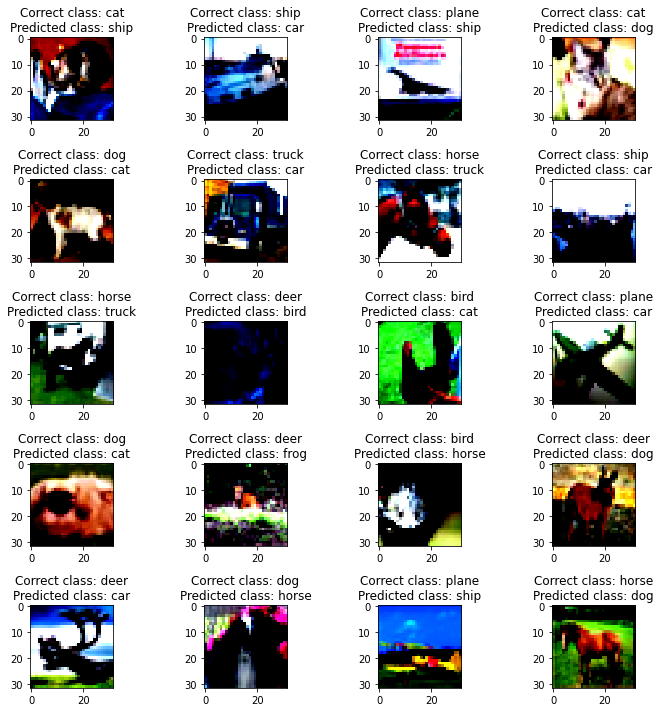

In [50]:
plot_misclassified_images(model, test_loader, classes, device)

In [51]:
def plot_loss_accuracy_graph_OneCLR(trainAcc, trainLoss, testAcc, testLoss):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    ax[0].plot(trainLoss, label='Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss vs. Epochs')
    ax[0].legend()

    ax2 = ax[0].twinx()
    ax2.plot(testLoss, label='Test Loss', color='red')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='center right')

    # Accuracy Plot
    ax[1].plot(trainAcc, label='Training Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy vs. Epochs')
    ax[1].legend()

    ax2 = ax[1].twinx()
    ax2.plot(testAcc, label='Test Accuracy', color='red')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='center right')

    plt.tight_layout()
    plt.show()


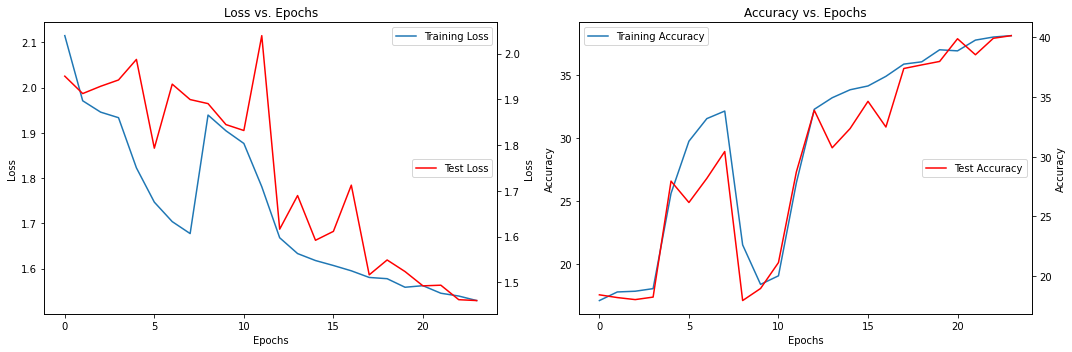

In [52]:
plot_loss_accuracy_graph_OneCLR(history[0], history[1], history[2], history[3])